## Segmentation data

In [1]:
import pandas as pd
seg_df = pd.read_csv('data/003_segments.csv')
seg_df['is_female'] = seg_df.gender == 'female'
seg_sub = seg_df.drop(['Segment', 'gender'], axis=1)
seg_sub.head()

,age,income,kids,own_home,subscribe,is_female
0,60.794945,57014.537526,0,True,False,False
1,61.764535,43796.941252,0,False,False,True
2,47.493356,51095.344683,0,True,False,False
3,60.963694,56457.722237,0,True,True,False
4,60.594199,103020.070798,0,True,False,True


## Classification

In [2]:
# Split data in train and test.
import numpy as np

seg_labels = seg_df.Segment

np.random.seed(537)
rand_idx = np.random.rand(seg_labels.shape[0])

train_idx = rand_idx <= 0.7
test_idx = rand_idx > 0.7

X_train = seg_sub.iloc[train_idx]
X_test = seg_sub.iloc[test_idx]

y_train = seg_labels.iloc[train_idx]
y_test = seg_labels.iloc[test_idx]

### Naive bayes

In [3]:
# Priori likelihood of segment membership - 27.1% for Moving up segment, 32.2% for Suburb mix segment.
from sklearn import naive_bayes 

nb = naive_bayes.GaussianNB()

nb.fit(X_train, y_train)

list(zip(nb.classes_, nb.class_prior_))

[('moving_up', 0.27102803738317754),
 ('suburb_mix', 0.32242990654205606),
 ('travelers', 0.2523364485981308),
 ('urban_hip', 0.1542056074766355)]

In [4]:
# Comparing the prediction and true_segment columns, the model appears to be performing well: only a
# single row does not match. The model has used those other fields, age, income, kids, etc., to 
# generate a reasonable prediction.
predictions = nb.predict(seg_sub)
seg_sub_pred = seg_sub.copy()
seg_sub_pred['prediction'] = predictions
seg_sub_pred['true_segment'] = seg_df['Segment']
seg_sub_pred.sample(5)

,age,income,kids,own_home,subscribe,is_female,prediction,true_segment
183,32.806946,60752.625106,5,False,False,True,moving_up,moving_up
194,43.302666,71789.130948,1,False,False,False,suburb_mix,moving_up
201,34.294615,62236.114534,5,False,False,False,moving_up,moving_up
99,31.673893,75433.895743,3,True,False,False,suburb_mix,suburb_mix
10,79.650722,32013.086824,0,True,False,False,travelers,travelers


In [5]:
# This returns an accuracy score, the agreement between predicted and actual segment membership, 
# which in this case is about 85%.
nb.score(X_test, y_test)

0.8488372093023255

In [6]:
# F1 = 2 * (precision * recall) / (precision + recall).
# precision = true positives / (true positives + false positives)
# recall = true positives / (true positives + false negatives)
from sklearn import metrics

y_pred = nb.predict(X_test)

metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

0.8532809445929236

In [7]:
# Confusion matrix.
# Precision can be read from the rows of the confusion matrix. In this case, the NB model 
# demonstrated a precision of 100% for the Urban hip segment (17/17), 96% for the travelers segment
# (26/27), 87.5% for the Suburban mix segment (21/24), and only 50% for the Moving up segment (9/18).

# Recall (sensitivity) can be read from the columns of the confusion matrix. Here the NB model demonstrated a 
# recall of 100% for the Urban hip (17/17) and Travelers (26/26) segments, but only 68% for the
# Suburban mix segment (21/31), and 75% for the Moving up segment (9/12).
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred, model):
  conf_mat = metrics.confusion_matrix(y_true, y_pred)

  sns.heatmap(conf_mat.T,
              xticklabels=model.classes_, yticklabels=model.classes_,
              annot=True, fmt='d')
  plt.xlabel('true label')
  plt.ylabel('predicted label')

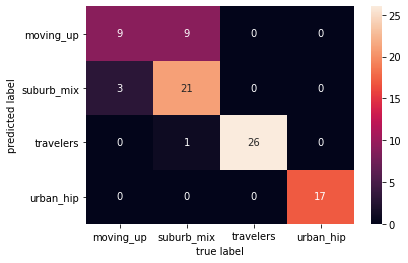

In [8]:
confusion_matrix(y_test, y_pred, nb)

In [9]:
def return_precision_recall(y_true, y_pred, model):
  conf_mat = metrics.confusion_matrix(y_true, y_pred)

  precision = pd.Series(metrics.precision_score(y_test,
                                                y_pred,
                                                average=None),
                        index=model.classes_)
  recall = pd.Series(metrics.recall_score(y_test,
                                          y_pred,
                                          average=None),
                     index=model.classes_)
  
  f1 = pd.Series(2 * (precision * recall)/(precision + recall),
                 index=model.classes_)

  return pd.DataFrame([precision, recall, f1], index=['precision',
                                                      'recall', 'f1'])

In [10]:
# There is likely to be a different business gain for identifying true positives and true negatives,
# versus the costs of false positives and false negatives. If you have estimates of these costs, you
# can use the confusion matrix to compute a custom metric for evaluating your classiﬁcation results.
return_precision_recall(y_test, y_pred, nb)

,moving_up,suburb_mix,travelers,urban_hip
precision,0.50,0.875000,0.962963,1.0
recall,0.75,0.677419,1.000000,1.0
f1,0.60,0.763636,0.981132,1.0


In [11]:
from sklearn import clone, decomposition

def plot_decision_pca(model, X, y):
  width, height = 500, 500

  # Transform the X values using a PCA
  p = decomposition.PCA(random_state=132, svd_solver='full')
  X_transformed = p.fit_transform(X.iloc[:,:2])

  # Pull the first two dimensions
  x0 = X_transformed[:, 0]
  x1 = X_transformed[:, 1]

  # Get evenly spaced values between the min and max values
  x0_g = np.linspace(x0.min(), x0.max(), width)
  x1_g = np.linspace(x1.min(), x1.max(), height)

  # Create a "grid" of those evenly spaced values from each vector
  xx, yy = np.meshgrid(x0_g, x1_g)

  # Stack together all of the sampled values 
  X_grid_transformed = np.vstack([xx.ravel(), yy.ravel()]).T

  # Do the inverse transform to get the non-PCA transformed values
  X_grid = p.inverse_transform(X_grid_transformed)

  # Fit a clone of the model using use inverse transformed columns
  # From the first two PCA dimensions.
  # Predict values on the sampled values
  model_c = clone(model)
  model_c.fit(p.inverse_transform(np.vstack([x0, x1]).T), y)
  X_grid_labels = model_c.predict(X_grid)

  # Create a class mapper to map from class string to an integer
  class_mapper = {class_:i for i,class_ in enumerate(model.classes_)}

  plt.figure(figsize=(6,6))
  # Plot the predicted values
  a = plt.scatter(x0, x1,
                  c=[class_mapper[label] for label in y],
                  cmap=plt.cm.rainbow, edgecolor='k', vmin=0, vmax=3)
  plt.contourf(xx, yy,
               np.reshape([class_mapper[label]
                           for label in X_grid_labels],
                          (width, height)),
              cmap=a.cmap, alpha=0.5, levels=3)
  cb = plt.colorbar(ticks=[0.5, 1.2, 2, 2.8])
  _ = cb.ax.set_yticklabels(model.classes_)
  plt.title('Decision boundaries with true values overlaid')
  plt.xlabel('First principal component')
  plt.ylabel('Second principal component')

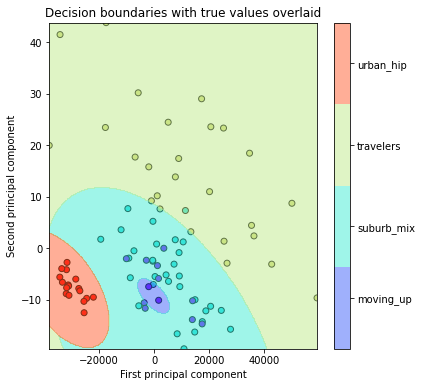

In [12]:
# Mapping the decision boundaries in PCA space exposes why the model discriminates poorly between the
# Suburban mix and Moving up segments: they are interspersed in the ﬁrst two principal components.
plot_decision_pca(nb, X_test, y_test)

In [13]:
pd.DataFrame(nb.predict_proba(seg_sub),
             columns=nb.classes_).sample(5).round(4)

,moving_up,suburb_mix,travelers,urban_hip
26,0.0000,0.0065,0.9935,0.0
188,0.7116,0.2851,0.0033,0.0
263,0.0000,0.0000,0.0000,1.0
129,0.5240,0.4759,0.0001,0.0
192,0.5957,0.4043,0.0000,0.0


This tells us that Respondent 188 is estimated to be about 71% likely to be a member of Moving up, yet 29% likely to
be in Suburban mix. Respondent 26 is estimated nearly 100% likely to be in Travelers. This kind of individual-level detail
can suggest which individuals to target according to the difficulty of targeting and the degree of certainty. For high-cost
campaigns, we might target only those most certain to be in a segment; whereas for low-cost campaigns, we might target
people for second-best segment membership in addition to primary segment assignment. Because we are able to predict
membership for new cases that have not been assigned, we can score new customers or others in a database, as long as we
have the relevant predictor data used in the classification model.

### Random forest classification
A random forest (RF) classiﬁer does not attempt to ﬁt a single model to data but instead builds an ensemble of models that
jointly classify the data.

In [14]:
from sklearn import ensemble

np.random.seed(23432)
rf = ensemble.RandomForestClassifier(n_estimators=50)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [15]:
rf.score(X_test, y_test)

0.7558139534883721

In [16]:
# The RF model performed a bit less well than the NB model, but is still a reasonably strong ﬁt.
y_pred = rf.predict(X_test)

metrics.f1_score(y_test, y_pred, average='weighted')

0.7582299105153958

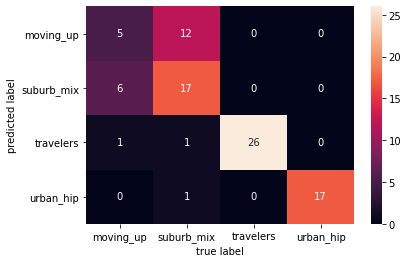

In [17]:
confusion_matrix(y_test, y_pred, rf)

In [18]:
return_precision_recall(y_test, y_pred, rf)

,moving_up,suburb_mix,travelers,urban_hip
precision,0.294118,0.739130,0.928571,0.944444
recall,0.416667,0.548387,1.000000,1.000000
f1,0.344828,0.629630,0.962963,0.971429


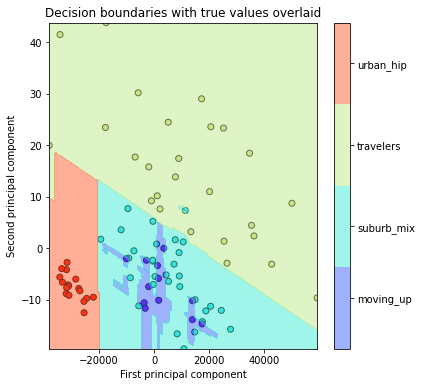

In [19]:
plot_decision_pca(rf, X_test, y_test)

In [20]:
def pairwise_decision_boundary(model, X_train, y_train,
                               X_test, y_test,
                               first_column, second_column,
                               jitter=False):
    width, height = 1000, 1000
    # Create a class mapper to map from class string to an integer
    class_mapper = {c:i for i,c in enumerate(model.classes_)}
    
    x0 = X_train[first_column]
    x1 = X_train[second_column]
    # Get evenly spaced values between the min and max values
    x0_g = np.linspace(x0.min(), x0.max(), width)
    x1_g = np.linspace(x1.min(), x1.max(), height)
    
    # Create a "grid" of those evenly spaced values from each vector
    xx, yy = np.meshgrid(x0_g, x1_g)   
    # Stack together all of the sampled values
    X_grid = np.vstack([xx.ravel(), yy.ravel()]).T    
    
    model_c = clone(model)
    model_c.fit(X_train.loc[:,[first_column, second_column]], y_train)
    X_grid_labels = model_c.predict(X_grid)
    # Plot the predicted values
    j_x0, j_x1 = 0, 0
    if jitter:
      j_x0 = (np.random.random(X_test.shape[0])-0.5)/10.
      j_x1 = (np.random.random(X_test.shape[0])-0.5)/10.
    a = plt.scatter(X_test[first_column] + j_x0,
                    X_test[second_column] + j_x1,
                    c=[class_mapper[l] for l in y_test],
                    cmap=plt.cm.rainbow, 
                    edgecolor='k', vmin=0, vmax=3)
    plt.contourf(xx, yy,
                 np.reshape([class_mapper[l] for l in X_grid_labels],
                            (width, height)),
                cmap=a.cmap, alpha=0.5, levels=3)
    plt.title('Decision boundaries with true values overlaid')
    plt.xlabel(first_column)
    plt.ylabel(second_column)
    cb = plt.colorbar(ticks=[0.5, 1.2, 2, 2.8])
    cb.ax.set_yticklabels(model.classes_)

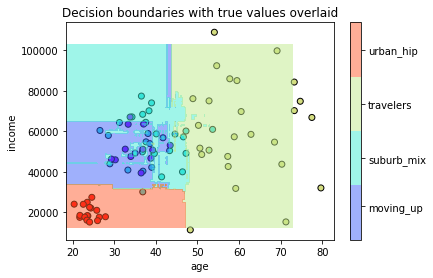

In [21]:
pairwise_decision_boundary(rf, X_train, y_train, X_test, y_test,
                           'age', 'income')

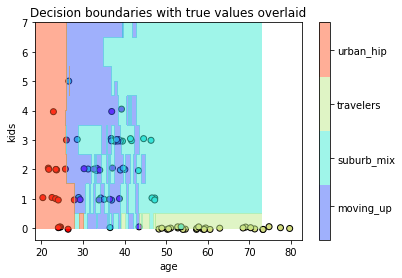

In [22]:
pairwise_decision_boundary(rf, X_train, y_train, X_test, y_test,
                           'age', 'kids', jitter=True)

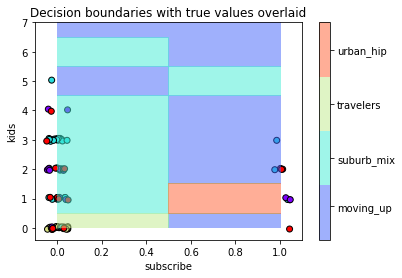

In [23]:
pairwise_decision_boundary(rf, X_train, y_train, X_test, y_test,
                           'subscribe', 'kids', jitter=True)

In [24]:
pd.DataFrame(rf.predict_proba(X_test), columns=rf.classes_).sample(5)

,moving_up,suburb_mix,travelers,urban_hip
76,0.00,0.00,0.00,1.0
19,0.02,0.06,0.92,0.0
39,0.24,0.76,0.00,0.0
73,0.00,0.00,0.00,1.0
56,0.10,0.76,0.14,0.0


the model has
assigned 100% probability that samples 73 and 76 are in the Urban hip segment. Samples 39 and 56 each have a 76% chance of being in the Suburban mix segment, but sample 39 is next most likely to be in Moving up, whereas for sample 56 its
second-most-likely class is Traveler.

### Random forest variable importance

In [25]:
# Age and income are the most useful variables, which is consistent with the decision boundaries
# visualizations. Understanding variable importance can enable a deeper understanding of the features
# that define differences between classes, enabling more intelligent business decisions.
pd.Series(rf.feature_importances_,
          index=seg_sub.columns).sort_values(ascending=False)

age          0.437028
income       0.313560
kids         0.150136
is_female    0.035421
own_home     0.032164
subscribe    0.031691
dtype: float64

## Prediction: identifying potential customers

Attempt to predict subscription status from our dataset seg_sub.

In [26]:
# Split train and test.
subscribe_label = seg_sub.subscribe

seg_sub_nosub = seg_sub.drop('subscribe', axis=1)

np.random.seed(7885)
rand_idx = np.random.rand(subscribe_label.shape[0])
train_idx = rand_idx <= 0.65
test_idx = rand_idx > 0.65

X_train = seg_sub_nosub.iloc[train_idx]
X_test = seg_sub_nosub.iloc[test_idx]

y_train = subscribe_label.iloc[train_idx]
y_test = subscribe_label.iloc[test_idx]

In [27]:
rf_sub = ensemble.RandomForestClassifier(n_estimators=100,
                                         random_state=86,
                                         class_weight=\
                                           'balanced_subsample')

rf_sub.fit(X_train, y_train)

y_pred = rf_sub.predict(X_test)

In [28]:
rf_sub.score(X_test, y_test)

0.9072164948453608

In [29]:
metrics.f1_score(y_test, y_pred, average='micro')

0.9072164948453608

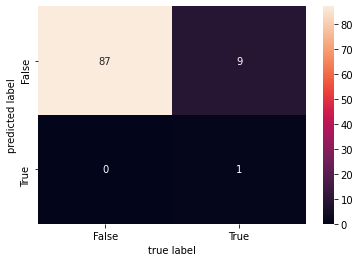

In [30]:
# The random forest model did not perform well a predicting the subscription state, achieving a
# recall of only 10% (1/10).
confusion_matrix(y_test, y_pred, rf_sub)

In [31]:
# A general solution is to balance the classes by sampling more from the small group. In RF models,
# this can be accomplished by telling the classifier to use a balanced group when it samples data to
# fit each tree.
from sklearn import model_selection

rf_sub_cv = ensemble.RandomForestClassifier(random_state=34,
                                            class_weight=\
                                              'balanced_subsample')
parameters = {'n_estimators': [10, 100, 500],
              'max_depth': [5, 10, 30],
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,2,5]}
clf = model_selection.GridSearchCV(rf_sub_cv, parameters,
                                   cv=5, scoring='f1_weighted')
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=34),
             param_grid={'max_depth': [5, 10, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 100, 500]},
             scoring='f1_weighted')

In [32]:
clf.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

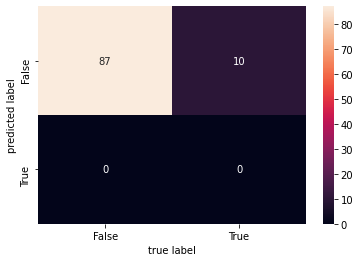

In [33]:
# Looking at the confusion matrix, we see that this model did not perform any better.
y_pred_be = clf.best_estimator_.predict(X_test)

confusion_matrix(y_test, y_pred_be, clf.best_estimator_)

In [34]:
# What if we try a different scoring function? Let's imagine we want to optimize for recall, that 
# is we want to ﬁnd as many potential positives as possible, accepting that many will be false
# positives. We can use recall as the scoring function.
rf_sub_cv = ensemble.RandomForestClassifier(random_state=34,
                                            class_weight=\
                                              'balanced_subsample')
parameters = {'n_estimators': [10, 100, 500],
              'max_depth': [5, 10, 30],
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,2,5]}
clf = model_selection.GridSearchCV(rf_sub_cv, parameters,
                                   cv=5, scoring='recall')
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=34),
             param_grid={'max_depth': [5, 10, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 100, 500]},
             scoring='recall')

In [35]:
clf.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 10}

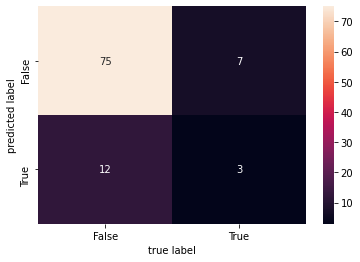

In [36]:
# Optimizing the hyperparameter tuning for recall improved the recall at the expense of precision.
y_pred_be = clf.best_estimator_.predict(X_test)

confusion_matrix(y_test, y_pred_be, clf.best_estimator_)

We have boosted our recall to 70% (7/10), but at a substantial cost to
precision: only 17.5% (7/40) of the observations that the model labeled as Trueare true positives; 33 were false positives.
Despite the fact that the variables here have poor predictive power, we can clearly see that optimizing our hyperparameter
tuning for a different score led to a differently tuned model with different tradeoffs. This is an important concept in machine
learning. An analyst should consider the business outcome carefully and tune a model appropriately. This often differs from
a generic or abstract "accuracy" metric. <br>
It's also worth nothing that machine learning is not magic, it is statistics. If there is no strong signal in the data, you cannot
build a good prediction. What should one do in that circumstance? The most obvious option would be to find other features
that might be more predictive.